# Example: empirical past-future bottleneck for Markov Chains
In this notebook, we will compute the Information Bottleneck between the past and the future of empirical data coming from simple markov chains. In the general Information Bottleneck framework we are interested in the relationship between two random variables $X$ and $Y$. Here we specialise this problem to the case where $X$ and $Y$ represent the "past" and the "future" of a time series. More specifically, if $X$ is a random variable representing a time series $\{\ldots,x_{t-2},x_{t-1},x_{t},x_{t+1},x_{t+2}\ldots\}$ and $M$ analogousy represents a "bottleneck variable", the idea is to compute

$
\min_{p(m|x_{\text{past}})}I(M:X_{\text{past}}) - \beta I(M:X_{\text{future}})
$

with the constraint that $M$ is independent of the future given the past, or

$
p(x_{\text{past}},m,x_{\text{future}}) = p(x_{\text{past}})p(m|x_{\text{past}})p(x_{\text{future}}|x_{\text{past}})
$

As we vary $\beta$, the corresponding values of $I_\text{past}:=I(M:X_{\text{past}})$ and $I_\text{future}:=I(M:X_{\text{past}})$ describe a bound that is the optimal tradeoff between compression and prediction [[Tishby, Pereira, Bialek 2001]](https://arxiv.org/abs/physics/0004057).

For simplicity, we will work here with order-1 Markov chains. Therefore, the infinite past and infinite future of the time series can be substituted in the expressions above by their one-step counterparts:

$
I_\text{past} = I(M_t:X_{t})
$

and

$
I_\text{future} = I(M_t:X_{t+1})
$

where $x_t$ and $m_t$ represent, respectively, the state of the time series and the bottleneck variable at time $t$.


## Preliminaries
We start with some standard imports and the configuration for matplotlib.

In [1]:
import numpy as np
import itertools
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
from embo import empirical_bottleneck

# matplotlib configuration
default_figsize = np.array((8.0, 6.8))/2.54 # division is to convert to inches
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.figsize'] = default_figsize
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[plt.get_cmap('Dark2',8)(k/7) for k in range(8)]) 

We then define some classes we will use to generate data. `FirstOrderMarkovChain` represents an n-state first-order Markov chain with given transition matrix. `NoisyTypeWriter` is a special type of Markov chain, where the transition matrix is such that each state will transition to itself or one of its k-nearest neighbors with equal probability.

In [2]:
class MarkovChain:
    def __init__(self, start=0):
        self.state = start
    def __iter__(self):
        return self
    def __next__(self):
        raise NotImplementedError
    def get_sample_chain(self, n):
        return [self.state] + list(itertools.islice(self, n-1))
    
class FirstOrderMarkovChain(MarkovChain):
    def __init__(self, transition_p=0.1, size=2, **kwargs):
        super().__init__(**kwargs)
        # define transition matrix: the i-th row is the conditional pdf for the next state given that current state is i.
        if np.isscalar(transition_p):
            assert 0 <= transition_p <= 1
            self.size = size
            self.transition_p = (1-transition_p)*np.eye(size) + (transition_p/(size-1))*(np.ones((size,size))-np.eye(size))
        else:
            assert transition_p.ndim==2 and transition_p.shape[0]==transition_p.shape[1]
            assert 0 <= transition_p.min() and transition_p.max() <= 1
            np.testing.assert_allclose(transition_p.sum(axis=1), 1)
            self.size = transition_p.shape[0]
            self.transition_p = transition_p
        # define cumulative transition matrix, useful to compute transitions
        self.cumulative_p = np.cumsum(self.transition_p, axis=1)
    def __str__(self):
        return "First Order Markov Chain with {} states and transition matrix:\n{}".format(self.size, self.transition_p)
    def __next__(self):
        self.state = np.searchsorted(self.cumulative_p[self.state], np.random.rand())
        return self.state

class NoisyTypewriter(FirstOrderMarkovChain):
    def __init__(self, size=5, noise_range=1, **kwargs):
        assert noise_range<=(size-1)/2
        p = 1/(1+noise_range*2)
        transition_p = np.diag(np.full(size, p))
        for r in range(1,noise_range+1):
            transition_p += np.diag(np.full(size-r, p), r)
            transition_p += np.diag(np.full(size-r, p), -r)
            transition_p += np.diag(np.full(r, p), size-r)
            transition_p += np.diag(np.full(r, p), -(size-r))
        super().__init__(transition_p=transition_p, **kwargs)

Let's visualize the transition matrices corresponding to the default settings for `MarkovChain` and `NoisyTypewriter`.

In [12]:
print(FirstOrderMarkovChain())

First Order Markov Chain with 2 states and transition matrix:
[[0.9 0.1]
 [0.1 0.9]]


In [4]:
print(NoisyTypewriter())

First Order Markov Chain with 5 states and transition matrix:
[[0.33333333 0.33333333 0.         0.         0.33333333]
 [0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.33333333 0.33333333 0.33333333]
 [0.33333333 0.         0.         0.33333333 0.33333333]]


## Empirical bottleneck for data coming from a binary Markov Chain
We start by generating data according to binary symmetric Markov Chains characterized by a range of "flip" probabilities from 0.025 (very sticky: the state at time $t$ is very likely to be the same as the state at time $t-1$) to 0.45 (very noisy: the state at time $t$ is only weakly correlated to the state at time $t-1$). For each of these datasets, we compute the Information Bottleneck.

In [5]:
pstep = 0.025
prange = np.arange(0.025, 0.45, pstep)

i_p = []
i_f = []
b = []

for k,p in enumerate(prange):
    c = FirstOrderMarkovChain(p)
    sample = c.get_sample_chain(100000)
    past, future, beta = empirical_bottleneck(sample[:-1],sample[1:], maxbeta=100, numbeta=1000, processes=4)
    i_p.append(past)
    i_f.append(future)
    b.append(beta)

We then plot $I_{\textrm{future}}$ and $I_{\textrm{past}}$ as a function of $\beta$ and of each other. Values corresponding to different chains with distinct "flip" probabilities are plotted with different colors.

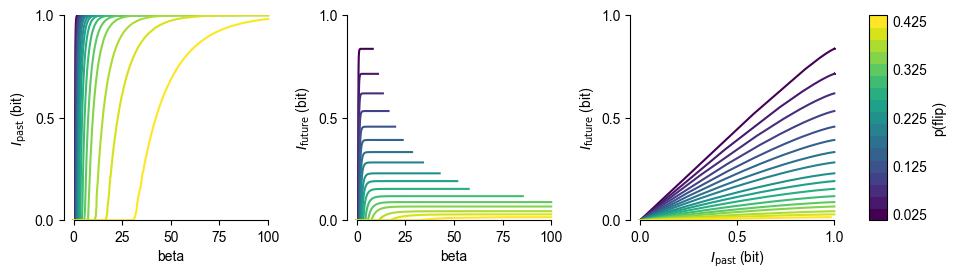

In [6]:
fig, ax = plt.subplots(constrained_layout=True, figsize=np.array((3,1))*default_figsize, ncols=3)
cm = plt.get_cmap('viridis',len(prange))
for k,p in enumerate(prange):
    past = i_p[k]
    future = i_f[k]
    beta = b[k]
    color = cm(k/(len(prange)-1))
    ax[0].plot(beta, past, color=color)
    ax[1].plot(beta, future, color=color)
    ax[2].plot(past, future, color=color)

cbar = plt.colorbar(
    matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=prange.min()-pstep/2, vmax=prange.max()+pstep/2), cmap=cm),
    ax=ax, ticks=prange[::4], location='right', aspect=40)
cbar.ax.tick_params(size=0)
cbar.set_label('p(flip)')
ax[0].set_xlabel('beta')
ax[0].set_ylabel("$I_{\mathrm{past}}$ (bit)")
ax[1].set_xlabel('beta')
ax[1].set_ylabel("$I_{\mathrm{future}}$ (bit)")
ax[2].set_xlabel("$I_{\mathrm{past}}$ (bit)")
ax[2].set_ylabel("$I_{\mathrm{future}}$ (bit)")

ax[2].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
for a in ax:
    a.set_ylim((0,1))
    a.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    for loc, spine in a.spines.items():
        spine.set_smart_bounds(True)

We can see that, as the flip probability increases and the chais become more noisy, the maximum $I_{\textrm{future}}$ (corresponding to the predictive information of the process) decreases, as our ability to predict the next state degrades. Note that the maximum $I_{\textrm{past}}$ is the same across all chains as the number of states is the same (2) and the marginal entropy over the states is 1 bit.

## Empirical bottleneck for data coming from a "noisy typewriter" chain
We do as above for a set of different "noisy typewriter" markov chains. The chains have a different number of states (6, 10, 14, 18 or 22), but we set them up to have all the same predictive information (1 bit). More in detail, in the chain with 6 states we allow each state to transition to itself or its immediate nearest neighbors with equal probability, so that by knowing the past state we halve our uncertainty about the future (with respect to a flat prior), going from 6 to 3 states. In the chain with 10 states, we allow each state to transition to itself or to one of its 2 nearest neighbors in either direction, so that there are 5 possible future states. Again, this way knowing the past halves our uncertainty about the future. We do analogously for the chains with 14, 18 and 22 states. The end result is that all chains have the same predictive information (1 bit), but they have different marginal entropies over the states, as each state is roughly equally probable and the chains have a different number of them.

In [7]:
size_range = np.array((6,10,14,18,22))
noise_range_range = np.array((1,2,3,4,5))

i_p_tw = []
i_f_tw = []
b_tw = []

for k,s in tqdm(enumerate(size_range)):
    c = NoisyTypewriter(size=s, noise_range=noise_range_range[k])
    sample = c.get_sample_chain(10000)
    past, future, beta = empirical_bottleneck(sample[:-1],sample[1:], maxbeta=25, numbeta=200, processes=4)
    i_p_tw.append(past)
    i_f_tw.append(future)
    b_tw.append(beta)

5it [05:48, 69.62s/it]


As above, we plot $I_{\textrm{future}}$ and $I_{\textrm{past}}$ as a function of $\beta$ and of each other.

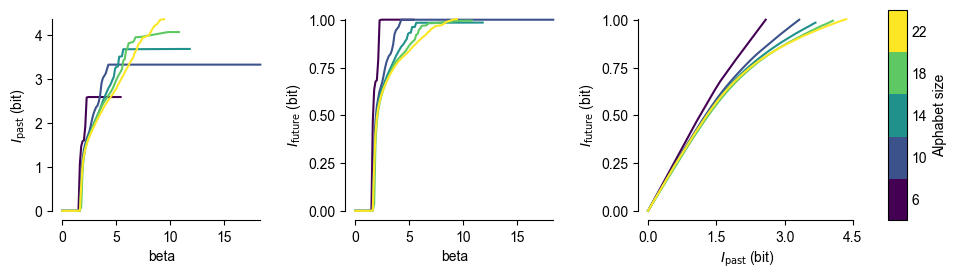

In [8]:
fig, ax = plt.subplots(constrained_layout=True, figsize=np.array((3,1))*default_figsize, ncols=3)
cm_tw = plt.get_cmap('viridis',len(size_range))
for k,s in enumerate(size_range):
    past = i_p_tw[k]
    future = i_f_tw[k]
    beta = b_tw[k]
    color = cm_tw(k/(len(size_range)-1))
    ax[0].plot(beta, past, color=color)
    ax[1].plot(beta, future, color=color)
    ax[2].plot(past, future, color=color)

cbar = plt.colorbar(
    matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=size_range.min()-2, vmax=size_range.max()+2), cmap=cm_tw),
    ax=ax, ticks=size_range, location='right', aspect=40)
cbar.ax.tick_params(size=0)
cbar.set_label('Alphabet size')
ax[0].set_xlabel('beta')
ax[0].set_ylabel("$I_{\mathrm{past}}$ (bit)")
ax[1].set_xlabel('beta')
ax[1].set_ylabel("$I_{\mathrm{future}}$ (bit)")
ax[2].set_xlabel("$I_{\mathrm{past}}$ (bit)")
ax[2].set_ylabel("$I_{\mathrm{future}}$ (bit)")


ax[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax[1].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.25))
ax[2].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.25))
ax[2].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(4))
for a in ax:
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    for loc, spine in a.spines.items():
        spine.set_smart_bounds(True)

We can see that, as the alphabet size increases, the marginal entropy of the states (the maximum of $I_{\text{past}}$) increases, but the predictive information (the maximum of $I_{\text{future}}$) stays the same. We can also observe that this implies that the bound becomes less and less linear as the alphabet size grows.

## Beyond first-order Markov chains: noisy logical gates
As a very simple example of second-order Markov chains, here we define chains based on noisy logical gates. For instance, `NoisyAndMarkovChain` is a chain where $x_t=x_{t-1}\land x_{t-2}$ with probability $p_{\mathrm{flip}}$, and  $x_t=\neg(x_{t-1}\land x_{t-2})$ otherwise.

In [9]:
class NoisyLogicalGateMarkovChain(MarkovChain):
    def __init__(self, flip_p=0.1, start_past=0, **kwargs):
        super().__init__(**kwargs)
        self.flip_p = flip_p
        self.state_past = start_past
    def __next__(self):
        new_state = self.gate()
        if np.random.rand() < self.flip_p:
            new_state = 1 - new_state
        self.state_past = self.state
        self.state = new_state
        return self.state
    def gate(self):
        raise NotImplementedError

class NoisyXorChain(NoisyLogicalGateMarkovChain):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def __str__(self):
        return "Noisy XOR Markov Chain with flip probability {}".format(self.flip_p)
    def gate(self):
        return self.state ^ self.state_past

class NoisyAndChain(NoisyLogicalGateMarkovChain):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def __str__(self):
        return "Noisy AND Markov Chain with flip probability {}".format(self.flip_p)
    def gate(self):
        return self.state & self.state_past

We generate data from `NoisyAndChain`s with different values of $p_\mathrm{flip}$, and we compute the past-future IB curve from this data using different-sized moving windows (size 1, 2 and 3) to define the past. More specifically, window size 1 is the same as we did in the examples above: $I_\text{past} = I(M_t:X_{t})$ and $I_\text{future} = I(M_t:X_{t+1})$. Window size 2 corresponds to enlarging the moving window we use to define the past by taking $I_\text{past} = I(M_t:\{X_{t-1},X_{t}\})$, and window size 3 consists in taking $I_\text{past} = I(M_t:\{X_{t-2},X_{t-1},X_{t}\})$.

In [10]:
p_delta = 0.10
p_flip_range = np.arange(0.05, 0.50, p_delta)
window_size_range = [1,2,3]

i_p_lg = np.zeros((len(p_flip_range), len(window_size_range)), dtype='O')
i_f_lg = np.zeros((len(p_flip_range), len(window_size_range)), dtype='O')
b_lg = np.zeros((len(p_flip_range), len(window_size_range)), dtype='O')

for k,p in tqdm(enumerate(p_flip_range)):
    c = NoisyAndChain(flip_p=p)
    sample = c.get_sample_chain(10000)
    for i,w in enumerate(window_size_range): 
        past, future, beta = empirical_bottleneck(sample[:-1],sample[1:], window_size_x=w, maxbeta=35, numbeta=400, processes=4)
        i_p_lg[k,i] = past
        i_f_lg[k,i] = future
        b_lg[k,i] = beta

5it [00:31,  6.35s/it]


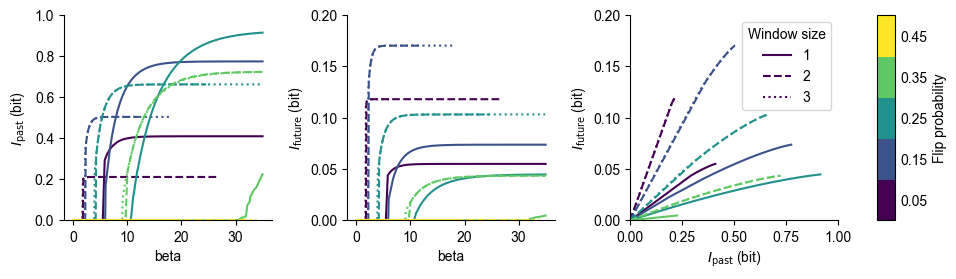

In [11]:
fig, ax = plt.subplots(constrained_layout=True, figsize=np.array((3,1))*default_figsize, ncols=3, nrows=1)
cm_lg = plt.get_cmap('viridis',len(p_flip_range))
for k,p in enumerate(p_flip_range):
    for i,window_size in enumerate(window_size_range): 
        past = i_p_lg[k,i]
        future = i_f_lg[k,i]
        beta = b_lg[k,i]
        color = cm_lg(k/(len(p_flip_range)-1))
        linestyle = ['-', '--', ':'][i]
        ax[0].plot(beta, past, color=color, linestyle=linestyle)
        ax[1].plot(beta, future, color=color, linestyle=linestyle)
        ax[2].plot(past, future, color=color, linestyle=linestyle)

cbar = plt.colorbar(
    matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=p_flip_range.min()-p_delta/2, vmax=p_flip_range.max()+p_delta/2), cmap=cm_lg),
    ax=ax, ticks=p_flip_range, location='right', aspect=40)
cbar.ax.tick_params(size=0)
cbar.set_label('Flip probability')
ax[0].set_xlabel('beta')
ax[0].set_ylabel("$I_{\mathrm{past}}$ (bit)")
ax[1].set_xlabel('beta')
ax[1].set_ylabel("$I_{\mathrm{future}}$ (bit)")
ax[2].set_xlabel("$I_{\mathrm{past}}$ (bit)")
ax[2].set_ylabel("$I_{\mathrm{future}}$ (bit)")
ax[2].legend(
    title='Window size',
    handles=[
        matplotlib.lines.Line2D([], [], color=cm_lg(0), linestyle='-', label=1),
        matplotlib.lines.Line2D([], [], color=cm_lg(0), linestyle='--', label=2),
        matplotlib.lines.Line2D([], [], color=cm_lg(0), linestyle=':', label=3)
])

ax[0].set_ylim((0,1))
ax[1].set_ylim((0,0.2))
ax[2].set_ylim((0,0.2))
ax[2].set_xlim((0,1))
for a in ax.flat:
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

Note how the IB curve gets steeper going from window size 1 (solid lines) to window size 2 (dashed lines), but doesn't change at all in going from window size 2 (dashed lines) to window size 3 (dotted lines - these are rarely visible as they are typically superimposed to the dashed lines). This reflects the fact that the Markov chain is of order 2, so a time window of size 2 $\{x_{t-1},x_t\}$ contains all the available information about the future state $x_{t+1}$, and using a time window of size 3 $\{x_{t-2},x_{t-1},x_t\}$ does not yield any extra information about the future.